<a href="https://colab.research.google.com/github/KendallScott/Machine-Learning/blob/main/Lab%202/Lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from yellowbrick.classifier import ConfusionMatrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report


In [10]:
# read the files into a dataframe
forest_cover_type = pd.read_csv('covtype.csv') 

# verify the dataframe loaded
print(forest_cover_type.shape)
forest_cover_type.head()

(581012, 55)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


# Data Preparation

In [11]:
# Data clean-up
# make list of continuous variables
continuous_variables = ['Elevation', 
                        'Aspect', 
                        'Slope', 
                        'Horizontal_Distance_To_Hydrology', 
                        'Vertical_Distance_To_Hydrology',
                        'Horizontal_Distance_To_Roadways',
                        'Hillshade_9am','Hillshade_Noon',
                        'Hillshade_3pm',
                        'Horizontal_Distance_To_Fire_Points']

# use list to make df
continuous_variables_df = forest_cover_type[continuous_variables]

# subset df to make binary categorical
# second number not inclusive
Wilderness_Area = forest_cover_type.iloc[:, 10:14]
Wilderness_Area['Wilderness_Area'] = Wilderness_Area.idxmax(axis = 1)

# subset df to make binary categorical
# second number not inclusive
Soil_Type = forest_cover_type.iloc[:, 14:54]
Soil_Type['Soil_Type'] = Soil_Type.idxmax(axis = 1)

# only keep the new column
Soil_Type = Soil_Type[['Soil_Type']]
Wilderness_Area = Wilderness_Area[['Wilderness_Area']]

# Add new columns to df
forest_cover_type['Soil_Type'] = Soil_Type
forest_cover_type['Wilderness_Area'] = Wilderness_Area

# delete first few characters in column so we only have number
forest_cover_type['Soil_Type'] = forest_cover_type['Soil_Type'].str[9:]
forest_cover_type['Wilderness_Area'] = forest_cover_type['Wilderness_Area'].str[15:]


# delete superfluous columns now that new columns are added
forest_cover_type.drop(forest_cover_type.iloc[:, 10:54], 
                       axis = 1, 
                       inplace = True)



<ipython-input-11-19057e19dc31>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Wilderness_Area['Wilderness_Area'] = Wilderness_Area.idxmax(axis = 1)
<ipython-input-11-19057e19dc31>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Soil_Type['Soil_Type'] = Soil_Type.idxmax(axis = 1)


In [12]:
# Convert to category data type
forest_cover_type['Cover_Type'] = forest_cover_type['Cover_Type'].astype('category')
forest_cover_type['Soil_Type'] = forest_cover_type['Soil_Type'].astype('category')
forest_cover_type['Wilderness_Area'] = forest_cover_type['Wilderness_Area'].astype('category')

In [13]:
# Check the data types
forest_cover_type.dtypes

Elevation                                int64
Aspect                                   int64
Slope                                    int64
Horizontal_Distance_To_Hydrology         int64
Vertical_Distance_To_Hydrology           int64
Horizontal_Distance_To_Roadways          int64
Hillshade_9am                            int64
Hillshade_Noon                           int64
Hillshade_3pm                            int64
Horizontal_Distance_To_Fire_Points       int64
Cover_Type                            category
Soil_Type                             category
Wilderness_Area                       category
dtype: object

In [14]:
forest_cover_type

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Soil_Type,Wilderness_Area
0,2596,51,3,258,0,510,221,232,148,6279,5,29,1
1,2590,56,2,212,-6,390,220,235,151,6225,5,29,1
2,2804,139,9,268,65,3180,234,238,135,6121,2,12,1
3,2785,155,18,242,118,3090,238,238,122,6211,2,30,1
4,2595,45,2,153,-1,391,220,234,150,6172,5,29,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,3,2,3
581008,2391,152,19,67,12,95,240,237,119,845,3,2,3
581009,2386,159,17,60,7,90,236,241,130,854,3,2,3
581010,2384,170,15,60,5,90,230,245,143,864,3,2,3


## Data Meaning 

Attributes:	

- 10 quantitative variables
  - Elevation - Elevation in meters
  - Aspect - Aspect in degrees azimuth
  - Slope - Slope in degrees
  - Horizontal Distance to Hydrology - Horz Dist to nearest surface water features (meters)
  - Vertical Distance to Hydrology - Vert Dist to nearest surface water features (meters)
  - Horizontal Distance to Roadways - Horz Dist to nearest roadway (meters)
  - Hill shade 9 am (0 to 255 index) - Hillshade index at 9am, summer solstice
  - Hill shade noon (0 to 255 index) - Hillshade index at noon, summer solstice
  - Hill shade 3 pm (0 to 255 index) - Hillshade index at 3pm, summer solstice
  - Horizontal distance to fire points - Horz Dist to nearest wildfire ignition points (meters)


- 3 Categorical variables
	- Wilderness area
  - 1: Neota
  - 2: Rawah
  - 3: Comanche Peak
  - 4: Cache la Poudre
	- Cover Type
  - 1: Spruce/Fir
  - 2: Lodgepole Pine
  - 3: Ponderosa Pine
  - 4: Cottonwood/Willow
  - 5: Aspen
  - 6: Douglas-fir
  - 7: Krummholz
	- Soil Type
		- 1: Cathedral family - Rock outcrop complex, extremely stony.
		- 2: Vanet - Ratake families complex, very stony.
		- 3: Haploborolis - Rock outcrop complex, rubbly.
		- 4: Ratake family - Rock outcrop complex, rubbly.
		- 5: Vanet family - Rock outcrop complex complex, rubbly.
		- 6: Vanet - Wetmore families - Rock outcrop complex, stony.
		- 7: Gothic family.
		- 8: Supervisor - Limber families complex.
		- 9: Troutville family, very stony.
		- 10: Bullwark - Catamount families - Rock outcrop complex, rubbly.
		- 11: Bullwark - Catamount families - Rock land complex, rubbly.
		- 12: Legault family - Rock land complex, stony.
		- 13: Catamount family - Rock land - Bullwark family complex, rubbly.
		- 14: Pachic Argiborolis - Aquolis complex.
		- 15: unspecified in the USFS Soil and ELU Survey.
		- 16: Cryaquolis - Cryoborolis complex.
		- 17: Gateview family - Cryaquolis complex.
		- 18: Rogert family, very stony.
		- 19: Typic Cryaquolis - Borohemists complex.
		- 20: Typic Cryaquepts - Typic Cryaquolls complex.
		- 21: Typic Cryaquolls - Leighcan family, till substratum complex.
		- 22: Leighcan family, till substratum, extremely bouldery.
		- 23: Leighcan family, till substratum - Typic Cryaquolls complex.
		- 24: Leighcan family, extremely stony.
		- 25: Leighcan family, warm, extremely stony.
		- 26: Granile - Catamount families complex, very stony.
		- 27: Leighcan family, warm - Rock outcrop complex, extremely stony.
		- 28: Leighcan family - Rock outcrop complex, extremely stony.
		- 29: Como - Legault families complex, extremely stony.
		- 30: Como family - Rock land - Legault family complex, extremely stony.
		- 31: Leighcan - Catamount families complex, extremely stony.
		- 32: Catamount family - Rock outcrop - Leighcan family complex, extremely stony.
		- 33: Leighcan - Catamount families - Rock outcrop complex, extremely stony.
		- 34: Cryorthents - Rock land complex, extremely stony.
		- 35: Cryumbrepts - Rock outcrop - Cryaquepts complex.
		- 36: Bross family - Rock land - Cryumbrepts complex, extremely stony.
		- 37: Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.
		- 38: Leighcan - Moran families - Cryaquolls complex, extremely stony.
		- 39: Moran family - Cryorthents - Leighcan family complex, extremely stony.
		- 40: Moran family - Cryorthents - Rock land complex, extremely stony.	
	

We brought our original data down from 55 columns down to 13. This will, not only make it easier to view and understand the data, but also allow the machine to run the models we will create. 

We converted the following features into categorical features: Wilderness Area, Cover Type, Soil Type. The Soil Type feature was initially was spread out in binary columns for each type (40 of them). Wilderness Area was also like this, but just with less columns. Once combined into one column, the binary features were converted into categorical. 

The remaining 10 features are integer data types. The measurements used for these 10 features have no decimal point, so no need to convert to float. They have remained as an integer.

Using multiple continuous variables will help us create regression models, whereas having a few categorical features will allow for classification models. 



# Modeling and Evaluation

### Random Forest

#### Test/Train Split

In [15]:
# Make target variable and data variable
y = forest_cover_type[['Cover_Type']]
X = forest_cover_type.loc[:, forest_cover_type.columns != 'Cover_Type']

In [16]:
# Takes about 2 min

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Create a random forest model
rfc = RandomForestClassifier(n_estimators = 100)

# Train the model on the training data
rfc.fit(X_train, y_train)

# Predict on the testing data
y_pred = rfc.predict(X_test)

# Calculate the accuracy of model
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy:', accuracy) # 0.9625482990972695


<ipython-input-16-f61bcb71e7f9>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


Accuracy: 0.9625482990972695


In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.62      0.63      0.63     21422
           2       0.62      0.77      0.69     28128
           3       0.57      0.23      0.33      3603
           4       0.00      0.00      0.00       281
           5       0.00      0.00      0.00       894
           6       0.12      0.00      0.00      1744
           7       0.00      0.00      0.00      2029

    accuracy                           0.62     58101
   macro avg       0.28      0.23      0.24     58101
weighted avg       0.57      0.62      0.59     58101



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


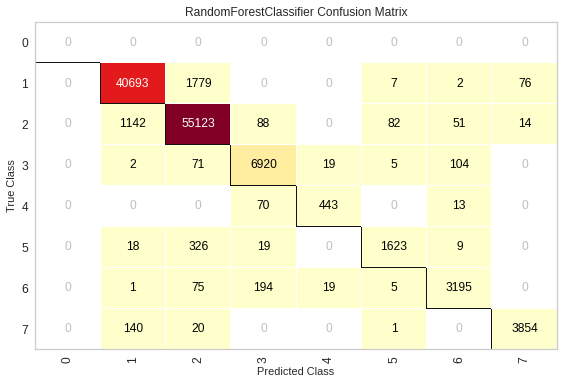

In [17]:
# Adapted from https://www.scikit-yb.org/en/latest/api/classifier/confusion_matrix.html

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(rfc, classes=[0, 1, 2, 3, 4, 5, 6, 7])

# Fit the model. 
cm.fit(X_train, y_train)

# Score runs predict() on the data and creates the confusion_matrix
cm.score(X_test, y_test)

cm.show();

#### Cross Validation

In [20]:
# Takes about 25 min

# Create a random forest classifier
rfc = RandomForestClassifier(n_estimators = 100)

# Create a stratified 10-fold cross-validation object
cv = KFold(n_splits = 10,
           shuffle = True, 
           random_state = 42)

# Iterate over the cross-validation splits
for train_idx, test_idx in cv.split(X, y):
    # Get the training and testing data for this split
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train the classifier on the training data
    rfc.fit(X_train, y_train)

    # Predict the classes of the testing data
    y_pred = rfc.predict(X_test)

    # Calculate the accuracy of the classifier
    accuracy = accuracy_score(y_test, y_pred)

    print('Accuracy:', accuracy) # mean accuracy: 0.96560656

<ipython-input-20-5bbb181131bb>:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


Accuracy: 0.9643213658738081


<ipython-input-20-5bbb181131bb>:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


Accuracy: 0.9654228770093972


<ipython-input-20-5bbb181131bb>:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


Accuracy: 0.9647854598027573


<ipython-input-20-5bbb181131bb>:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


Accuracy: 0.9665238119825821


<ipython-input-20-5bbb181131bb>:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


Accuracy: 0.9650780537340149


<ipython-input-20-5bbb181131bb>:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


Accuracy: 0.9665582347980242


<ipython-input-20-5bbb181131bb>:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


Accuracy: 0.9654567047038777


<ipython-input-20-5bbb181131bb>:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


Accuracy: 0.9659558355277879


<ipython-input-20-5bbb181131bb>:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


Accuracy: 0.9669368857678869


<ipython-input-20-5bbb181131bb>:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


Accuracy: 0.9650264195108518


In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Create a random forest classifier
rfc = RandomForestClassifier(n_estimators=100)

# Create a K-fold cross-validation object
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize arrays to store the evaluation metrics
precisions = []
recalls = []
f1_scores = []

# Iterate over the cross-validation splits
for train_idx, test_idx in cv.split(X, y):
    # Get the training and testing data for this split
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train the classifier on the training data
    rfc.fit(X_train, y_train)

    # Predict the classes of the testing data
    y_pred = rfc.predict(X_test)

    # Calculate the precision, recall and F1-score of the classifier
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Append the metrics to the arrays
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Print the mean metrics across all folds
print("Precision:", sum(precisions) / len(precisions))
print("Recall:", sum(recalls) / len(recalls))
print("F1-score:", sum(f1_scores) / len(f1_scores))

<ipython-input-25-99e777b60a40>:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)
<ipython-input-25-99e777b60a40>:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)
<ipython-input-25-99e777b60a40>:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)
<ipython-input-25-99e777b60a40>:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)
<ipython-input-25-99e777b60a40>:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please

Precision: 0.96575151386226
Recall: 0.9657511398368959
F1-score: 0.9656278119193695


Precision: 0.96575151386226

Recall: 0.9657511398368959

F1-score: 0.9656278119193695

#### Stratified Cross Validation

In [ ]:
# Takes 25 min. about 2 min per fold

# Create a random forest classifier
rfc = RandomForestClassifier(n_estimators = 100)

# Create a stratified 10-fold cross-validation object
cv = StratifiedKFold(n_splits = 10, 
                     shuffle = True, 
                     random_state = 42)

# Iterate over the cross-validation splits
for train_idx, test_idx in cv.split(X, y):
    # Get the training and testing data for this split
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train the classifier on the training data
    rfc.fit(X_train, y_train)

    # Predict the classes of the testing data
    y_pred = rfc.predict(X_test)

    # Calculate the accuracy of the classifier
    accuracy = accuracy_score(y_test, y_pred)

    print('Accuracy:', accuracy) # mean accuracy: 0.96549469

### KNN

#### Test/Train Split

In [ ]:
# Takes 2.5 min

# Try different values of k to find the elbow point
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), inertia, marker = 'o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

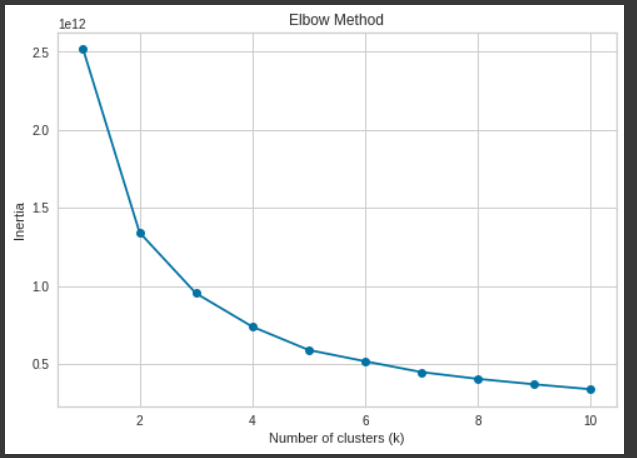

In [18]:
# Create a KNN classifier with k = 6
knn = KNeighborsClassifier(n_neighbors = 6)

# Train the classifier on the training data
knn.fit(X_train, y_train)

# Predict the classes of the testing data
y_pred = knn.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy:', accuracy) # 0.965844255311825

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:964: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(
/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


Accuracy: 0.965844255311825


In [ ]:
print(classification_report(y_test, y_pred))

#### Cross Validation

In [ ]:
# Create a k-NN classifier
knn = KNeighborsClassifier(n_neighbors = 6)

# Evaluate the model using 10-fold cross validation
scores = cross_val_score(knn, 
                         X, 
                         y, 
                         cv = 10)


# Print the accuracy of each fold and the mean accuracy
print('\n')
print("Accuracy of each fold:", scores)
print('\n')
print("Mean accuracy:", scores.mean()) # Mean accuracy: 0.5362315601229429


#### Stratified Cross Validation 

In [19]:
# Use stratified 10 fold cross validation to evaluate the model
cv = StratifiedKFold(n_splits = 10)
scores = cross_val_score(knn, 
                         X, 
                         y, 
                         cv = cv)

# Print the accuracy of each fold and the mean accuracy
print('\n')
print("Accuracy of each fold:", scores)
print('\n')
print("Mean accuracy:", scores.mean()) # 0.5362315601229429

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:964: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(
/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.p

Accuracy of each fold: [0.60906681 0.49218616 0.59344934 0.55694394 0.4901981  0.52844185
 0.53351922 0.50188465 0.4732965  0.58332903]
Mean accuracy: 0.5362315601229429


### Logistic Regression

#### Test/Train Split

In [21]:
# Create a logistic regression classifier
lr = LogisticRegression()

# Train the classifier on the training data
lr.fit(X_train, y_train)

# Predict the classes of the testing data
y_pred = lr.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy:', accuracy) # 0.6241921465022418

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.6215211442143853


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


In [ ]:
print(classification_report(y_test, y_pred))

#### Cross Validation

In [22]:
# Perform 10-fold cross-validation and calculate the mean accuracy
cv_scores = cross_val_score(lr, X, y, cv = 10)
mean_accuracy = cv_scores.mean()

print('Cross-validation accuracy:', mean_accuracy) # 0.6009685968081737

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming

Cross-validation accuracy: 0.6009685968081737


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


#### Stratified Cross Validation

In [23]:
# Create a stratified 10-fold cross-validator
skf = StratifiedKFold(n_splits = 10)

# Perform cross-validation
cv_scores = cross_val_score(lr, X, y, cv = skf)

# Calculate the mean accuracy of the cross-validation scores
mean_accuracy = cv_scores.mean()

print('Cross-validation accuracy:', mean_accuracy)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming

Cross-validation accuracy: 0.6009685968081737


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


### Splitting Method

We looked at Train/Test Split to begin wih because it the most simplified and well-known form of data separation. We saw accuracy scores around 96% for Random Forest and kNN, but for Logistic Regression it dipped down to 62%. However, we have cause for concern with this method of splitting the data due to two of the Cover Types being highly skewed. Because of this, we looked at other data separation techniques. 

We use Stratified 10 Fold Cross Validation to help with the imbalanced dataset. This implements a fold in the data where each fold has the same ratio of instances of target variable as in the whole dataset. However, we saw a huge time increase in running this model. So something we have to consider is if the additional time is worth it? 

For our specific dataset, we saw about the same accuracy score. We had to look at some other performance metrics to gain a better understanding if the additional time is worth it. 

### Analyze Results 

**Accuracy Scores for various splitting methods vs models**

Splitting Method   | Random Forest | KNN    | Logistic
-------------------|---------------|--------|---------
Test/Train         | 0.9625        | 0.9658 | 0.6242
Cross Validation   | 0.9656        | 0.5362 | 0.6009
Stratified CV      | 0.9655        | 0.5362 | 0.6009

### SVM

takes too long

In [ ]:
from sklearn.svm import SVC

# Create an SVM classifier
svm = SVC(kernel='linear')

# Train the classifier on the training data
svm.fit(X_train, y_train)

# Predict the classes of the testing data
y_pred = svm.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy:', accuracy)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV

# Create an SVM classifier
svm = LinearSVC()

# Define the hyperparameters to search over
parameters = {'C': [0.1, 1, 10, 100]}

# Create a grid search object to search over the hyperparameters
grid_search = GridSearchCV(svm, parameters, cv=5)

# Fit the grid search object on the training data
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
svm = grid_search.best_estimator_

# Predict the classes of the testing data
y_pred = svm.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy:', accuracy)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y

### Testing out a pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


# Define the classifiers
svm = SVC(kernel='linear', C=1)
logistic = LogisticRegression(solver='liblinear')
rfc = RandomForestClassifier(n_estimators=100)

# Define the pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', 'passthrough')
])

# Set up the hyperparameters to be tuned for each model
svm_params = {'classifier': [svm]}
logistic_params = {'classifier': [logistic]}
rfc_params = {'classifier': [rfc]}

# Add the parameter dictionaries to a list
params = [svm_params, logistic_params, rfc_params]


# Train the pipeline on the training data
pipe.fit(X_train, y_train)

# Predict the classes of the testing data using the pipeline
y_pred = pipe.predict(X_test)

# Calculate the accuracy of the pipeline
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy:', accuracy)

AttributeError: ignored

When the classes are imbalanced, the area under the Receiver Operating Characteristic (ROC) curve (AUC) is a useful evaluation metric. The ROC curve plots the true positive rate (sensitivity) against the false positive rate (1-specificity) at various thresholds. The AUC represents the probability that a randomly selected positive example will be ranked higher than a randomly selected negative example.